# CoV vs Influenza vs HD Classification

In [1]:
import glob
from pathlib import Path
from tqdm.notebook import tqdm

import torch
from transformers import (
    EsmTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import datasets
from datasets import ClassLabel

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## load results

In [2]:
path = "/home/jovyan/shared/mahdi/1_projects/model_optimization/07HDvsFluvsCov/results/*.csv"
files = glob.glob(path)
len(files)

15

In [3]:
dataset_map = {
    'full': 'F',
    'half': 'H',
    'quarter': 'Q'
}
def combine_stats(list_of_paths):
    # read all results files and combine
    dfs = []
    for path in list_of_paths:
        tmp = pd.read_csv(path)

        # remove precalculated mean and std
        tmp = tmp[:-2]

        # get model name
        tmp["model"] = Path(path).stem
        
        dfs.append(tmp)
    
    df = pd.concat(dfs).reset_index(drop=True)
    
    df['dataset'] = df['model'].str.split('_').str[2].map(dataset_map)
    df['model_size'] = df['model'].str.split('_').str[1].str.replace('M', '').astype(int)

    # get means and errors
    means = df.groupby(["model_size", "dataset"]).mean(numeric_only=True)
    sem = df.groupby(["model_size", "dataset"]).sem(numeric_only=True)

    # combine in a readable table format
    combined = means.copy()
    for i in means.index:
        for j in [col for col in means.columns if "test" in col]:
            combined.loc[i,j] = f"{str(round(means.loc[i,j], 4))} (\xB1 {str(round(sem.loc[i,j], 4))})"

    return df, combined

In [4]:
full_df, summary = combine_stats(files)

## summary of Dataset-F results

In [5]:
summary.xs("F", level="dataset")

,itr,test_loss,test_accuracy,test_macro-precision,test_macro-recall,test_macro-f1,test_micro-precision,test_micro-recall,test_micro-f1,mcc,test_mcc,test_runtime,test_samples_per_second,test_steps_per_second
model_size,,,,,,,,,,,,,,
8,2.0,0.8927 (± 0.0051),0.6073 (± 0.0021),0.6232 (± 0.004),0.6073 (± 0.0021),0.6059 (± 0.0023),0.6073 (± 0.0021),0.6073 (± 0.0021),0.6073 (± 0.0021),NaN,0.4171 (± 0.0032),1.0579 (± 0.0149),832.1198 (± 11.9669),26.4884 (± 0.3798)
35,2.0,0.8259 (± 0.0085),0.6257 (± 0.0058),0.6464 (± 0.0048),0.6257 (± 0.0058),0.6257 (± 0.0057),0.6257 (± 0.0058),0.6257 (± 0.0058),0.6257 (± 0.0058),NaN,0.4462 (± 0.008),1.8451 (± 0.0792),480.176 (± 20.1902),15.2852 (± 0.6429)
150,2.0,0.7704 (± 0.0061),0.6583 (± 0.0046),0.6729 (± 0.0032),0.6583 (± 0.0046),0.6583 (± 0.0049),0.6583 (± 0.0046),0.6583 (± 0.0046),0.6583 (± 0.0046),NaN,0.4932 (± 0.0052),4.1901 (± 0.1079),210.5028 (± 5.6069),6.7006 (± 0.1779)
350,2.0,0.7237 (± 0.004),0.6762 (± 0.0022),0.6847 (± 0.0031),0.6762 (± 0.0021),0.6768 (± 0.0027),0.6762 (± 0.0022),0.6762 (± 0.0022),0.6762 (± 0.0022),NaN,0.5172 (± 0.0028),5.266 (± 0.0207),167.0464 (± 0.7006),5.3172 (± 0.0209)
650,2.0,0.7497 (± 0.0083),0.6612 (± 0.0072),0.6635 (± 0.0089),0.6612 (± 0.0072),0.6617 (± 0.0079),0.6612 (± 0.0072),0.6612 (± 0.0072),0.6612 (± 0.0072),NaN,0.4923 (± 0.0109),8.2329 (± 0.0412),106.8508 (± 0.55),3.4014 (± 0.0171)


## inference for confusion matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
# models and corresponding test data
class_dict = {
    n: {
        "models": {
            "350M-F": f"/home/jovyan/shared/mahdi/1_projects/model_optimization/07HDvsFluvsCov/350M_full/models/350M_full_HD-Flu-CoV_itr-{n}_2025-02-19",
        },
        "data": f"../data/5_folded/hd-0_flu-1_cov-2_test{n}.csv"
    }
for n in range(5)}

In [ ]:
# run inference on entire test set
for i in tqdm(class_dict.keys()):

    # load test data
    test_data = pd.read_csv(class_dict[i]["data"])
    test_preds = test_data.copy() # for storing prediction metrics
    
    class_labels = ClassLabel(names=['Healthy-Donor', 'Flu-specific', 'CoV-specific'])
    n_classes = len(class_labels.names)
    label2id = {'Healthy-Donor':0, 'Flu-specific':1, 'CoV-specific':2}
    id2label = {0:'Healthy-Donor', 1:'Flu-specific', 2:'CoV-specific'}
    
    # make huggingface dataset
    dataset = datasets.Dataset.from_pandas(test_data)
    dataset = dataset.cast_column("label", class_labels)
    
    # filter for length (model has max length of 320 from training)
    def filter_long_sequences(item):
        return (len(item['h_sequence'])+len(item['l_sequence'])) <= 315 # allows 4 tokens (start, sep (which is 2 tokens long), end)
    filtered = dataset.filter(filter_long_sequences)
    
    # tokenizer
    tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t30_150M_UR50D")
    
    def preprocess_dataset(
        batch, 
        tokenizer=None, 
        tokenizer_path="./tokenizer", 
        separator="<cls><cls>",
        max_len=320
    ) -> list:
        """
        docstring
        """
        # tokenize the H/L sequence pair
        sequences = [h + separator + l for h, l in zip(batch["h_sequence"], batch["l_sequence"])]
        tokenized = tokenizer(sequences, padding="max_length", max_length=max_len)
        batch["input_ids"] = tokenized.input_ids
        batch["attention_mask"] = tokenized.attention_mask
        
        return batch
    
    # tokenize
    tokenized_dataset = filtered.map(
        preprocess_dataset,
        fn_kwargs={
            "tokenizer": tokenizer,
            "max_len": 320,
        },
        batched=True,
        remove_columns=["name", "h_sequence", "l_sequence"]
    )

    # load each model
    for model_id, model_path_str in class_dict[i]["models"].items():
        print(f"{i}: {model_id}")
        model = AutoModelForSequenceClassification.from_pretrained(model_path_str).to(device)
    
        # predict on test set and get metrics
        trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=TrainingArguments(output_dir="./", 
                                   report_to="none"), # to turn off wandb logging
            eval_dataset=tokenized_dataset,
        )
        logits, labels, metrics = trainer.predict(tokenized_dataset)
        probabilities = torch.softmax(torch.from_numpy(logits), dim=1).detach().numpy()[:, -1]
        predictions = np.argmax(logits, axis=1)
        
        del model # free up memory
        
        # categorize predictions
        pred_data = []
        for pred, prob, label, logit in zip(predictions, probabilities, labels, logits):
            if pred == label == 1:
                category = "true_positive"
            elif pred == label == 0:
                category = "true_negative"
            elif pred == 1 and label == 0:
                category = "false_positive"
            else:
                category = "false_negative"
            pred_data.append(
                {
                    # "label": label,
                    f"{model_id}_prediction": pred,
                    f"{model_id}_probability": prob,
                    f"{model_id}_category": category,
                    f"{model_id}_logits": logit,
                }
            )
        pred_df = pd.DataFrame(pred_data)
        
        # store predictive performance with its corresponding sequence
        test_preds = pd.concat([test_preds, pred_df], axis=1)
    
    # save as csv
    save_path = f"./results/all_predictions_itr{i}.csv"
    print(f"saving to csv: {save_path} \n-------------------\n\n")
    test_preds.to_csv(save_path, index=False)

## plot confusion matrix

In [6]:
# dict to load test data with predictions
preds = [f"/home/jovyan/shared/mahdi/1_projects/model_optimization/07HDvsFluvsCov/KN_inference/results/all_predictions_itr{i}.csv" for i in range(5)]

def itr_col(path, itr):
    df = pd.read_csv(path)
    df["itr"] = itr
    return df

all_preds = [itr_col(preds[itr], itr) for itr in range(len(preds))]
all_preds = pd.concat(all_preds, ignore_index=True) 

# drop NaNs
all_preds = all_preds[~all_preds["350M-F_prediction"].isna()]

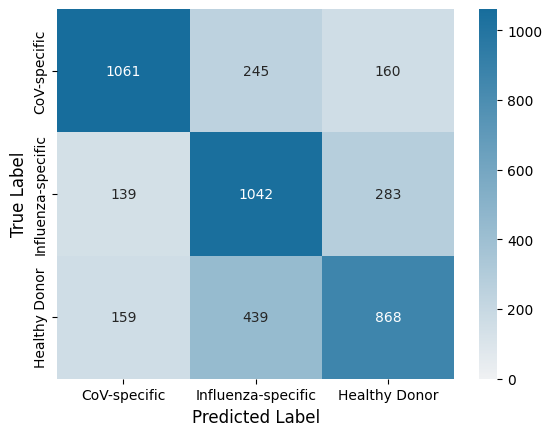

In [7]:
# reorder columns
all_preds["reordered_label"] = all_preds["label"].map({0:2, 1:1, 2:0})
all_preds["reordered_pred"] = all_preds["350M-F_prediction"].map({0:2, 1:1, 2:0})

cm = confusion_matrix(
    all_preds["reordered_label"], 
    all_preds["reordered_pred"]
)


sns.heatmap(
    cm, annot=True, fmt="d",
    cmap=sns.light_palette(
        "#176D9C",
        as_cmap=True
    ),
    vmin=0, vmax=cm.max()
)

plt.xlabel("Predicted Label", fontsize=12)
plt.xticks([0.5,1.5,2.5], 
            ['CoV-specific', 'Influenza-specific', 'Healthy Donor'],
            rotation="horizontal", 
            fontsize=10)
plt.ylabel("True Label", fontsize=12)
plt.yticks([0.5,1.5,2.5], 
            ['CoV-specific', 'Influenza-specific', 'Healthy Donor'],
            rotation="vertical", 
            fontsize=10)

plt.savefig("multiclass_conf-matrix.pdf", bbox_inches='tight', dpi=300)